# VQVAE on Fashion MNIST
by Paulo Roberto DE MOURA JÚNIOR

Based on https://arxiv.org/pdf/1711.00937v2

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

Define hyperparameters

In [18]:
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 20
IMAGE_SIZE = 28
CHANNELS = 1
HIDDEN_DIM = 128
EMBED_DIM = 64
NUM_EMBEDDINGS = 128
COMMITMENT_COST = 0.25

Load dataset and create dataloaders

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='dataset', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='dataset', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(0), num_workers=os.cpu_count())
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda:0


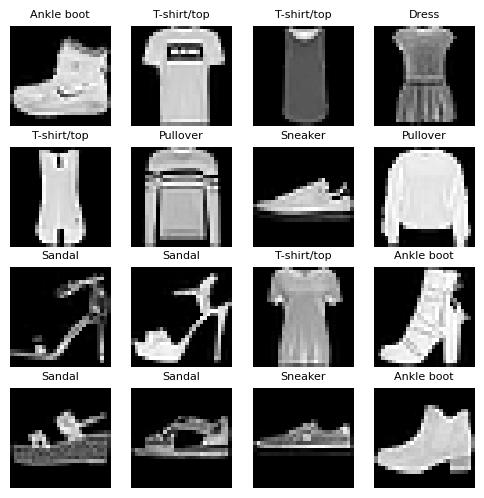

In [20]:
# show some images with labels
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(trainset[i][0].squeeze(), cmap='gray')
    plt.title(trainset.classes[trainset[i][1]], fontsize=8)
    plt.axis('off')

Implement model architecture, here chosen as a 3-layer CNN for both encoder and decoder for simplicity

In [21]:
class Encoder(nn.Module):
    def __init__(self, in_channels=CHANNELS, hidden_dim=HIDDEN_DIM, latent_dim=EMBED_DIM):
        """CNN encoder network for VQ-VAE.
        """
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        """
        x: shape (N, in_channels, H, W)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        """Vector quantization layer of VQ-VAE.
        """
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # codebook (num_embeddings, embedding_dim)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.normal_()

    def forward(self, z):
        """
        z: shape (N, embed_dim, H, W)
        """
        z = z.permute(0, 2, 3, 1).contiguous() # (N, H, W, embed_dim)
        z_shape = z.shape

        flat_z = z.view(-1, self.embedding_dim)

        distances = (torch.sum(flat_z**2, dim=1, keepdim=True) - 2 * torch.matmul(flat_z, self.embedding.weight.t()) + torch.sum(self.embedding.weight**2, dim=1))

        encoding_indices = torch.argmin(distances, dim=1) # (N*H*W)

        quantized = self.embedding(encoding_indices)  # (N*H*W, embed_dim)

        quantized = quantized.view(z_shape) # (N, H, W, embed_dim)

        # vq loss computation
        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        vq_loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # straight-through trick
        quantized = z + (quantized - z).detach()

        quantized = quantized.permute(0, 3, 1, 2).contiguous() # (N, embed_dim, H, W)

        return quantized, vq_loss, encoding_indices

class Decoder(nn.Module):
    def __init__(self, out_channels=CHANNELS, hidden_dim=HIDDEN_DIM, latent_dim=EMBED_DIM):
        """ CNN decoder network for VQ-VAE."""
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(latent_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(hidden_dim, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        """
        x: shape (N, latent_dim, H, W)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

class VQVAE(nn.Module):
    def __init__(self, in_channels=CHANNELS, hidden_dim=HIDDEN_DIM, embed_dim=EMBED_DIM, num_embeddings=NUM_EMBEDDINGS, commitment_cost=COMMITMENT_COST):
        """VQ-VAE model.
        """
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_dim, embed_dim)
        self.vq = VectorQuantizer(num_embeddings, embed_dim, commitment_cost)
        self.decoder = Decoder(in_channels, hidden_dim, embed_dim)

    def forward(self, x):
        """
        x: shape (N, in_channels, H, W)
        """
        z_e = self.encoder(x)
        z_q, vq_loss, _ = self.vq(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss

Train loop: with Adam optimizer and MSE reconstruction loss

In [22]:
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
print(model)

VQVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (vq): VectorQuantizer(
    (embedding): Embedding(128, 64)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)


In [23]:
# training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    # training
    model.train()
    running_loss = 0.0
    
    loader_iter = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=True)

    for batch_idx, (x, _) in enumerate(loader_iter):
        x = x.to(device)

        x_recon, vq_loss = model(x)
        
        recon_loss = F.mse_loss(x_recon, x)
        total_loss = recon_loss + vq_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # validation
    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon, vq_loss = model(x)
            
            recon_loss = F.mse_loss(x_recon, x)
            total_loss = recon_loss + vq_loss

            val_running_loss += total_loss.item()
    
    val_epoch_loss = val_running_loss / len(test_loader)
    val_losses.append(val_epoch_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] - train loss: {epoch_loss:.4f} - val loss: {val_epoch_loss:.4f}")

    # save model if validation loss has decreased
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'vqvae_model.pth')

Epoch [1/20]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/20]: 100%|██████████| 469/469 [00:06<00:00, 67.05it/s]


Epoch [1/20] - train loss: 0.6258 - val loss: 0.7008


Epoch [2/20]: 100%|██████████| 469/469 [00:06<00:00, 67.56it/s]


Epoch [2/20] - train loss: 0.4279 - val loss: 0.2997


Epoch [3/20]: 100%|██████████| 469/469 [00:07<00:00, 66.65it/s]


Epoch [3/20] - train loss: 0.2493 - val loss: 0.2187


Epoch [4/20]: 100%|██████████| 469/469 [00:06<00:00, 68.23it/s]


Epoch [4/20] - train loss: 0.1986 - val loss: 0.1815


Epoch [5/20]: 100%|██████████| 469/469 [00:06<00:00, 67.98it/s]


Epoch [5/20] - train loss: 0.1772 - val loss: 0.1677


Epoch [6/20]: 100%|██████████| 469/469 [00:06<00:00, 67.60it/s]


Epoch [6/20] - train loss: 0.1634 - val loss: 0.1626


Epoch [7/20]: 100%|██████████| 469/469 [00:06<00:00, 67.51it/s]


Epoch [7/20] - train loss: 0.1573 - val loss: 0.1575


Epoch [8/20]: 100%|██████████| 469/469 [00:07<00:00, 66.19it/s]


Epoch [8/20] - train loss: 0.1483 - val loss: 0.1455


Epoch [9/20]: 100%|██████████| 469/469 [00:07<00:00, 66.97it/s]


Epoch [9/20] - train loss: 0.1478 - val loss: 0.1479


Epoch [10/20]: 100%|██████████| 469/469 [00:06<00:00, 67.66it/s]


Epoch [10/20] - train loss: 0.1500 - val loss: 0.1511


Epoch [11/20]: 100%|██████████| 469/469 [00:06<00:00, 67.38it/s]


Epoch [11/20] - train loss: 0.1512 - val loss: 0.1543


Epoch [12/20]: 100%|██████████| 469/469 [00:06<00:00, 67.13it/s]


Epoch [12/20] - train loss: 0.1523 - val loss: 0.1533


Epoch [13/20]: 100%|██████████| 469/469 [00:06<00:00, 67.45it/s]


Epoch [13/20] - train loss: 0.1492 - val loss: 0.1418


Epoch [14/20]: 100%|██████████| 469/469 [00:06<00:00, 67.33it/s]


Epoch [14/20] - train loss: 0.1361 - val loss: 0.1373


Epoch [15/20]: 100%|██████████| 469/469 [00:06<00:00, 67.34it/s]


Epoch [15/20] - train loss: 0.1347 - val loss: 0.1334


Epoch [16/20]: 100%|██████████| 469/469 [00:06<00:00, 68.16it/s]


Epoch [16/20] - train loss: 0.1352 - val loss: 0.1380


Epoch [17/20]: 100%|██████████| 469/469 [00:06<00:00, 67.39it/s]


Epoch [17/20] - train loss: 0.1354 - val loss: 0.1319


Epoch [18/20]: 100%|██████████| 469/469 [00:06<00:00, 67.28it/s]


Epoch [18/20] - train loss: 0.1345 - val loss: 0.1330


Epoch [19/20]: 100%|██████████| 469/469 [00:06<00:00, 67.78it/s]


Epoch [19/20] - train loss: 0.1325 - val loss: 0.1304


Epoch [20/20]: 100%|██████████| 469/469 [00:06<00:00, 67.75it/s]


Epoch [20/20] - train loss: 0.1253 - val loss: 0.1219


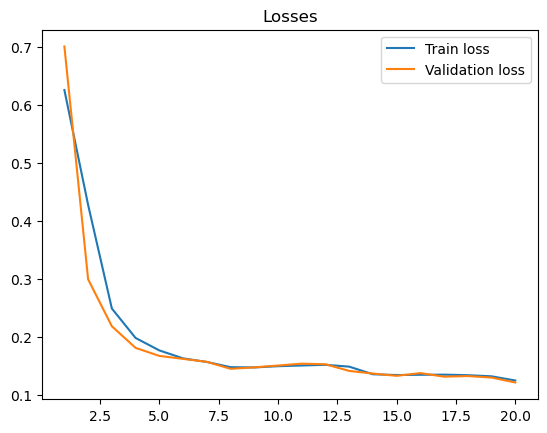

In [29]:
# plot losses
epochs = range(1, EPOCHS+1)
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Losses')
plt.legend()
plt.show()

Visualize some reconstructions

In [24]:
# load saved model checkpoint
model = VQVAE().to(device)
model.load_state_dict(torch.load('vqvae_model.pth'))

<All keys matched successfully>

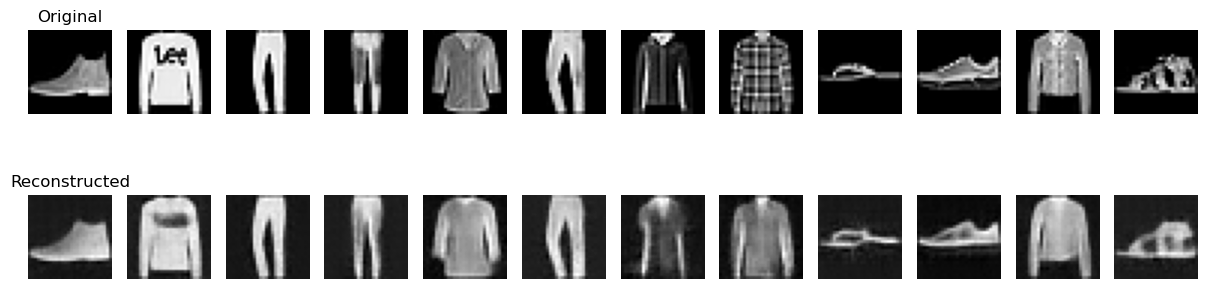

In [25]:
model.eval()
images, _ = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    x_recon, _ = model(images)

images = images.cpu().numpy()
x_recon = x_recon.cpu().numpy()

n = 12
plt.figure(figsize=(12, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i, 0], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_recon[i, 0], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title("Reconstructed")

plt.tight_layout()
plt.show()